In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [ ]:
X = mnist["data"]
y = mnist["target"]

In [ ]:
X.shape,y.shape

((70000, 784), (70000,))

### Viewing a digit from dataset

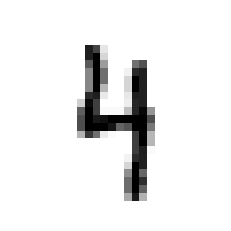

In [ ]:
import matplotlib as mpl
plt.imshow(X[1110].reshape(28,28), cmap="binary")
plt.axis("off")
plt.show()

### Converting output from string to integer

In [ ]:
y = y.astype(np.uint8)

### Splitting into training and test set

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training the binary classification model

In [ ]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)
print(y_train_5)

[ True False False ...  True False False]


In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(random_state = 69)# To produce the same results when running it another time, use random_state parameter
sgd_classifier.fit(X_train, y_train_5)

### Using the model on test data

In [ ]:
y_test_5 == sgd_classifier.predict(X_test)

### Measuring Performance

#### Using accuracy

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=2, scoring="accuracy")# The cv parameter is basically diving the test set into that many parts and training on one while testing on other

array([0.9625    , 0.96446667])

#### Using Confusion matrix

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)
# We dont want to use the test for now so we make predictions in train set
# cross_val_predict will perform K-fold cross-validation to predict from train set such that prediction made on an eg. is not used in training the model

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_train_5, y_train_pred)
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print(conf_matrix)
print(precision)
print(recall)
print(f1)

[[53054  1525]
 [  973  4448]]
0.7446844131927005
0.8205128205128205
0.7807618044584869


#### To get the score calculated by SGDClassifier of example we passed 

In [ ]:
# The way predict() works is that it it assign scores to each digit and compares it with a threshold and if score>threshold, it assigns 1 to it
# To get that score:
y_score = sgd_classifier.decision_function(X_train[0:1])
print(y_score)

# You can set your own threshold and compare y_score with that for more control

# get the scores for the whole dataset
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

# Also scores are PROBABLY p*1e4 and threshold = 0

[283.90369052]


#### Plotting precison recall curve

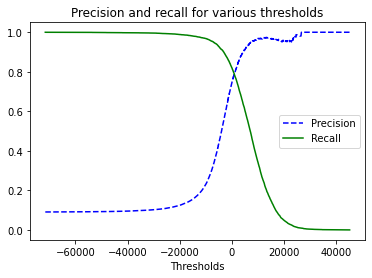

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")#Note the -1
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")#Note the -1
plt.xlabel('Thresholds')
plt.title('Precision and recall for various thresholds')
plt.legend()
plt.show()

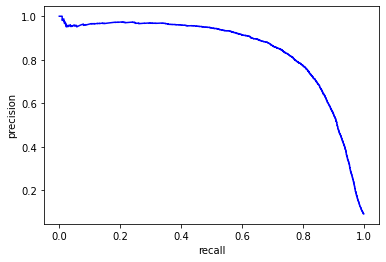

In [ ]:
plt.plot(recalls, precisions, 'b-')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

#### Setting your threshold based on required precison and recall

In [ ]:
threshold_for_70_precision = thresholds[np.argmax(precisions >= 0.70)]
print(threshold_for_70_precision)

y_pred_for_70_precision = y_scores >= threshold_for_70_precision

print(precision_score(y_train_5, y_pred_for_70_precision))

-808.9696396320992
0.7000765110941086


### Multi-class classification

Multiclass classification can be one vs one and one vs all.
In this part we are using SVM classifier and the sklearn will use one vs one for it automatically

#### Multi-class classification by SVM classifier

In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

array([5], dtype=uint8)

Digit Scores for a particular image

In [ ]:
digit_score = svm_classifier.decision_function(X_train[0:1])
print(digit_score)
# From the 45 classifiers (10*9/2) sklearn with assign score to each class and for predicting, take the maximum score

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


#### Manually selecting between OneVsRest and OneVsOne

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(SVC())
ovr_classifier.fit(X_train, y_train)
ovr_classifier.predict(X[0:1])

#### Multi-class classification by SGD classifier

In [ ]:
sgd_multi_classifier = SGDClassifier()
sgd_multi_classifier.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

#### Digit Scores for a particular image(SGD)

In [ ]:
scores = sgd_multi_classifier.decision_function(X_train[0:1])
print(scores)
#Note that for first example in X_train only 3 and 5 have positive values and actually it is 5

[[-18316.9111953  -18966.49519423  -9841.03966926   1645.86599908
  -24867.29259592   2496.2651888  -33879.50709837 -14634.1205774
   -8915.96402929  -9177.8685473 ]]


### Measuring Performance

#### Accuracy

In [ ]:
acc = cross_val_score(sgd_multi_classifier, X_train, y_train, cv=3, scoring="accuracy")
print(acc)

[0.8653 0.8566 0.8673]


#### Improving accuracy by feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
acc = cross_val_score(sgd_multi_classifier, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(acc)

[0.89605 0.88975 0.89925]


#### Analysing and visualising the confusion matrix

In [ ]:
y_train_pred = cross_val_predict(sgd_multi_classifier, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train_pred, y_train)
print(conf_mx)

# We dont want to use the test for now so we make predictions in train set
# cross_val_predict will perform K-fold cross-validation to predict from train set such that prediction made on an eg. is not used in training the model

[[5583    0   27   23   12   26   30   19   18   24]
 [   0 6405   27   17   14   15   15   10   65   18]
 [  23   37 5243  116   49   30   48   53   47   30]
 [   6   24   91 5241   12  170    2   31   87   65]
 [   9    4   75    2 5203   55   41   51    3  119]
 [  44   44   26  210   12 4472   96   12  122   37]
 [  37    4   69   27   36   78 5564    3   29    1]
 [   6    7   39   39   24   16    3 5711   11  179]
 [ 214  204  351  386  309  498  118  161 5422  333]
 [   1   13   10   70  171   61    1  214   47 5143]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


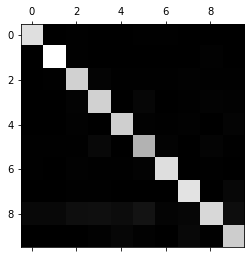

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

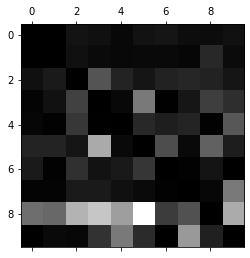

In [ ]:
#Sum of each row is the actual number of images of that class
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
#See that the 9th row is white it means that many number are being misclassified as 8